# Cifar10 classification tricks

In this notebook you will download the cifar10 dataset which contains quite small images (32x32x3) of 10 classes. The data is from the Canadian Institute For Advanced Research. You will plot examples of the images with the class label. Note that because the images are so small it is not always very easy to recognise which of the ten classes is on the image, even as a human. After loading the dataset you will train multiple models and compare the performances of the models on the testset.

**Dataset:**  You work with the Cifar10 dataset. You have 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck")

**Content:**
* load the original cifar10 data create a train val and test dataset
* visualize samples of cifar10 dataset

* train a random forest on the pixelvalues
* train a cnn from scratch without normalization
* train a cnn from scratch with normalization
* train a cnn from scratch with dropout
* train a cnn from scratch with batchnorm
* train a cnn from scratch with data augmentation

* compare the performances of the models


#### Imports

In the next two cells, we load all the required libraries and functions.

In [1]:
# load required libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
plt.style.use('default')
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import optimizers
from sklearn.ensemble import RandomForestClassifier



### Load and plot the data

In the next cell you will load the Cifar10 dataset, 50'000 images are in the training set and 10'000 are in the test dataset. You will use 10'000 for the train and validation dataset.
You will plot one random example of each label and will see
that the images are really small and finally you can convert the lables into the one hot encoding.


In [2]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# separate train val and test dataset
X_train=x_train[0:10000] 
Y_train=to_categorical(y_train[0:10000],10) # one-hot encoding

X_val=x_train[20000:30000] 
Y_val=to_categorical(y_train[20000:30000],10)

X_test=x_test 
Y_test=to_categorical(y_test,10)

del x_train, y_train, x_test, y_test


print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


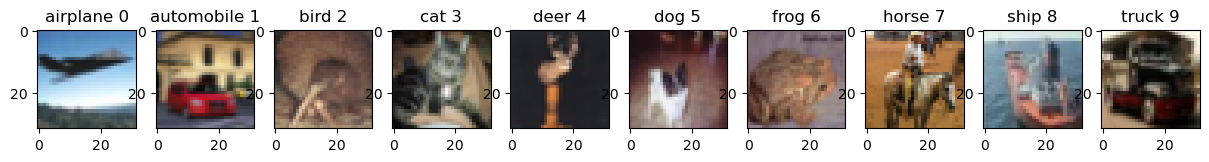

In [4]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
plt.figure(figsize=(15,15))
for i in range(0,len(np.unique(np.argmax(Y_train,axis=1)))):
    rmd=np.random.choice(np.where(np.argmax(Y_train,axis=1)==i)[0],1)
    plt.subplot(1,10,i+1)
    img=X_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(labels[i]+" "+str(np.argmax(Y_train,axis=1)[rmd][0]))

In [5]:
# check the shape of the data
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((10000, 32, 32, 3), (10000, 10), (10000, 32, 32, 3), (10000, 10))

### RF on pixelvalues
In this section you will train a random forest on the raw pixelvalues of the images.


In [6]:
clf = RandomForestClassifier(n_estimators=40,random_state=22)
clf.fit(X_train.reshape(len(X_train),32*32*3), np.argmax(Y_train,axis=1))

RandomForestClassifier(n_estimators=40, random_state=22)

In [7]:
pred=clf.predict(X_test.reshape(len(X_test),32*32*3))
acc=np.average(pred==np.argmax(Y_test,axis=1))
res1 = pd.DataFrame(
          {'Acc' : acc}, index=['rf on pixelvalues'])
res1

,Acc
rf on pixelvalues,0.393


### CNN from scratch wihout normalization
In this section you train a cnn from scratch to learn to classify the images into the right label. Normalization is not applied to the data.

In [8]:
model  =  Sequential()

model.add(Convolution2D(16,(3,3),activation="relu",padding="same",input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [9]:
history = model.fit(X_train, Y_train, 
                    batch_size=64,
                    epochs=10, validation_data=(X_val, Y_val),verbose=1)

Epoch 1/10
157/157 [==============================] - 16s 105ms/step - loss: 2.7987 - accuracy: 0.2961 - val_loss: 1.6849 - val_accuracy: 0.3837
Epoch 2/10
157/157 [==============================] - 17s 108ms/step - loss: 1.5020 - accuracy: 0.4538 - val_loss: 1.4516 - val_accuracy: 0.4734
Epoch 3/10
157/157 [==============================] - 18s 112ms/step - loss: 1.2763 - accuracy: 0.5353 - val_loss: 1.4387 - val_accuracy: 0.4745
Epoch 4/10
157/157 [==============================] - 18s 114ms/step - loss: 1.1325 - accuracy: 0.5940 - val_loss: 1.4102 - val_accuracy: 0.5105
Epoch 5/10
157/157 [==============================] - 17s 110ms/step - loss: 0.9313 - accuracy: 0.6682 - val_loss: 1.4038 - val_accuracy: 0.5251
Epoch 6/10
157/157 [==============================] - 18s 116ms/step - loss: 0.7674 - accuracy: 0.7263 - val_loss: 1.5167 - val_accuracy: 0.5308
Epoch 7/10
157/157 [==============================] - 18s 113ms/step - loss: 0.5878 - accuracy: 0.7902 - val_loss: 1.6596 - val_ac

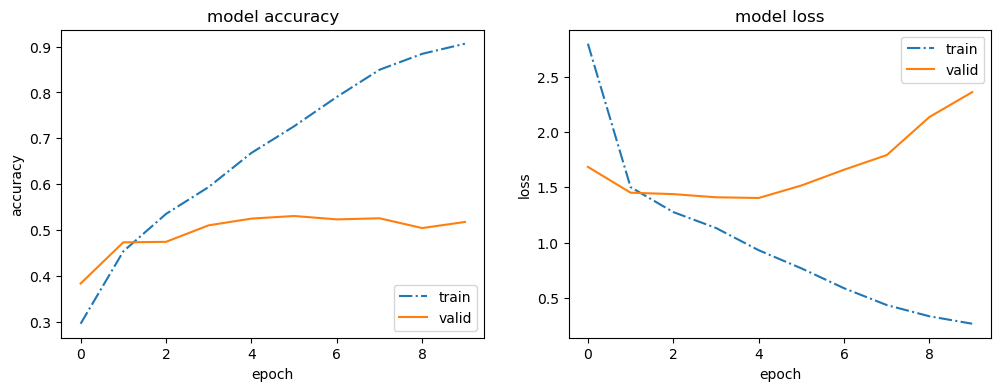

In [10]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [11]:
acc=np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
res2 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch without normalization']
)
pd.concat([res1,res2])

,Acc
rf on pixelvalues,0.393
cnn from scratch without normalization,0.515


### CNN from scratch with normalization
In this section you train a cnn from scratch to learn to classify the images into the right label. Normalization is applied to the data.

In [12]:
# normalization
X_train_norm = X_train/255
X_val_norm = X_val/255
X_test_norm = X_test/255

In [13]:
model  =  Sequential()

model.add(Convolution2D(16,(3,3),activation="relu",padding="same",input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

In [14]:
history = model.fit(X_train_norm, Y_train, 
                    batch_size=64,
                    epochs=10, validation_data=(X_val_norm, Y_val),verbose=1)

Epoch 1/10
157/157 [==============================] - 17s 109ms/step - loss: 1.9267 - accuracy: 0.2833 - val_loss: 1.6574 - val_accuracy: 0.3806
Epoch 2/10
157/157 [==============================] - 18s 113ms/step - loss: 1.5401 - accuracy: 0.4309 - val_loss: 1.4702 - val_accuracy: 0.4583
Epoch 3/10
157/157 [==============================] - 18s 115ms/step - loss: 1.3526 - accuracy: 0.4998 - val_loss: 1.3870 - val_accuracy: 0.5004
Epoch 4/10
157/157 [==============================] - 19s 118ms/step - loss: 1.2161 - accuracy: 0.5582 - val_loss: 1.3781 - val_accuracy: 0.5042
Epoch 5/10
157/157 [==============================] - 17s 108ms/step - loss: 1.0647 - accuracy: 0.6145 - val_loss: 1.2149 - val_accuracy: 0.5599
Epoch 6/10
157/157 [==============================] - 17s 105ms/step - loss: 0.9145 - accuracy: 0.6746 - val_loss: 1.1993 - val_accuracy: 0.5828
Epoch 7/10
157/157 [==============================] - 17s 106ms/step - loss: 0.7782 - accuracy: 0.7220 - val_loss: 1.3538 - val_ac

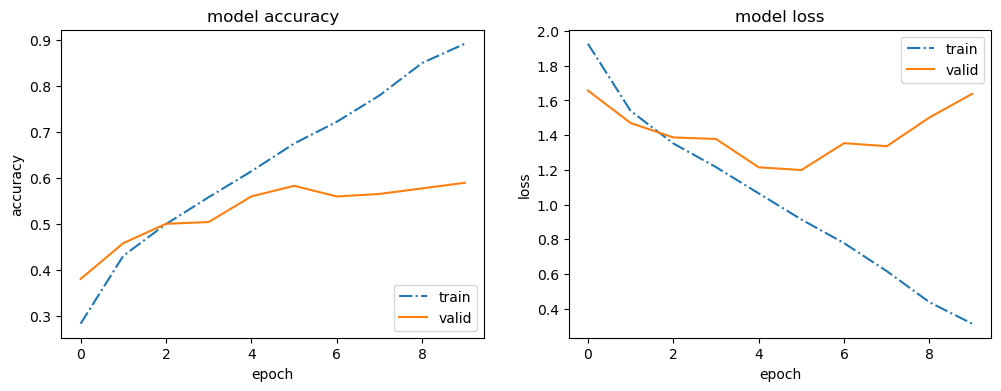

In [15]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [16]:
acc=np.average(np.argmax(model.predict(X_test_norm),axis=1)==np.argmax(Y_test,axis=1))
res3 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch with normalization']
)
pd.concat([res1,res2,res3])

,Acc
rf on pixelvalues,0.393
cnn from scratch without normalization,0.515
cnn from scratch with normalization,0.574


### CNN from scratch with Dropout
In this section you train a cnn from scratch to learn to classify the images into the right label. This time you will use dropout layers in the classification part. Normalization is not used.

In [17]:
model  =  Sequential()

model.add(Convolution2D(16,(3,3),activation="relu",padding="same",input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)             

In [18]:
history = model.fit(X_train, Y_train, 
                    batch_size=64,
                    epochs=20, validation_data=(X_val, Y_val),verbose=1)

Epoch 1/20
157/157 [==============================] - 38s 243ms/step - loss: 2.3236 - accuracy: 0.2080 - val_loss: 1.8702 - val_accuracy: 0.3147
Epoch 2/20
157/157 [==============================] - 30s 191ms/step - loss: 1.7850 - accuracy: 0.3403 - val_loss: 1.5899 - val_accuracy: 0.4226
Epoch 3/20
157/157 [==============================] - 26s 169ms/step - loss: 1.5973 - accuracy: 0.4221 - val_loss: 1.6121 - val_accuracy: 0.4320
Epoch 4/20
157/157 [==============================] - 27s 173ms/step - loss: 1.4400 - accuracy: 0.4757 - val_loss: 1.4281 - val_accuracy: 0.4862
Epoch 5/20
157/157 [==============================] - 25s 160ms/step - loss: 1.3579 - accuracy: 0.5149 - val_loss: 1.3922 - val_accuracy: 0.5068
Epoch 6/20
157/157 [==============================] - 23s 147ms/step - loss: 1.2589 - accuracy: 0.5493 - val_loss: 1.3287 - val_accuracy: 0.5298
Epoch 7/20
157/157 [==============================] - 22s 139ms/step - loss: 1.1835 - accuracy: 0.5702 - val_loss: 1.3011 - val_ac

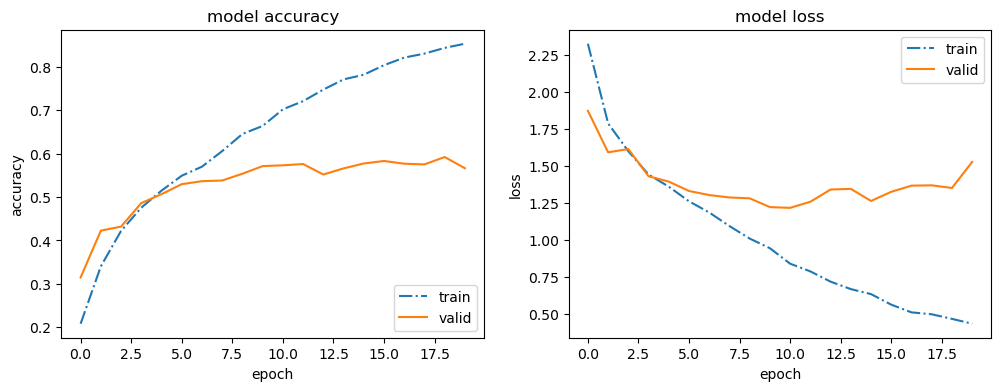

In [19]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [20]:
acc = np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
res4 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch with dropout']
)
pd.concat([res1,res2,res3,res4])

,Acc
rf on pixelvalues,0.3930
cnn from scratch without normalization,0.5150
cnn from scratch with normalization,0.5740
cnn from scratch with dropout,0.5604


### CNN from scratch with Batchnorm
In this section you train a cnn from scratch to learn to classify the images into the right label. This time you will use batchnorm on the input and in the convolutional part of the network. Note that we use the original images and do not normalize them.

In [21]:
# not normalized, values between 0 and 255
X_train[0,0:10,0,0]

array([ 59,  16,  25,  33,  50,  71,  97, 115, 137, 154], dtype=uint8)

In [22]:
model  =  Sequential()

model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(16,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(32,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 16)       

In [23]:
history = model.fit(X_train, Y_train, 
                    batch_size=64,
                    epochs=10, validation_data=(X_val, Y_val),verbose=1)

Epoch 1/10
157/157 [==============================] - 37s 234ms/step - loss: 1.6952 - accuracy: 0.3858 - val_loss: 1.8689 - val_accuracy: 0.3149
Epoch 2/10
157/157 [==============================] - 34s 215ms/step - loss: 1.3044 - accuracy: 0.5254 - val_loss: 1.2999 - val_accuracy: 0.5315
Epoch 3/10
157/157 [==============================] - 34s 219ms/step - loss: 1.1185 - accuracy: 0.5970 - val_loss: 1.1329 - val_accuracy: 0.5989
Epoch 4/10
157/157 [==============================] - 31s 196ms/step - loss: 0.9838 - accuracy: 0.6506 - val_loss: 1.3445 - val_accuracy: 0.5434
Epoch 5/10
157/157 [==============================] - 32s 205ms/step - loss: 0.8595 - accuracy: 0.6896 - val_loss: 1.1366 - val_accuracy: 0.6117
Epoch 6/10
157/157 [==============================] - 39s 248ms/step - loss: 0.7600 - accuracy: 0.7270 - val_loss: 1.1166 - val_accuracy: 0.6186
Epoch 7/10
157/157 [==============================] - 36s 231ms/step - loss: 0.6467 - accuracy: 0.7679 - val_loss: 1.4736 - val_ac

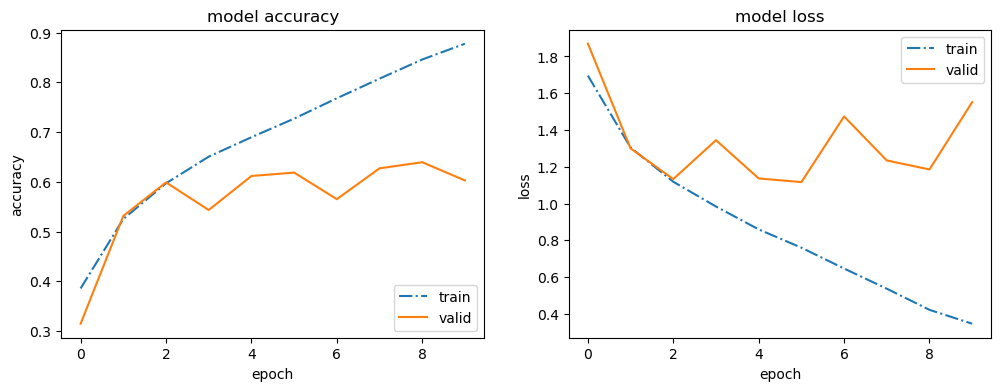

In [24]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [25]:
acc = np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
res5 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch with batchnorm']
)
pd.concat([res1,res2,res3,res4,res5])

,Acc
rf on pixelvalues,0.3930
cnn from scratch without normalization,0.5150
cnn from scratch with normalization,0.5740
cnn from scratch with dropout,0.5604
cnn from scratch with batchnorm,0.5926


#### Exercise
Calculate the confusion matrix of the networks.  
Play around with the dropout rate and the position of the batchnorm.

### CNN from scratch with Data Augmentation
In this section you train a cnn from scratch to learn to classify the images into the right label. This time you will use data augmentation, so the network will train on slightly different versions of the images in each epoch.

Data Augmentation is especially helpful if you do not have lots of data. Another approach to train with few data is to use a pretrained neural network. This will be covered in the next notebook. 

In [26]:
model  =  Sequential()

model.add(Convolution2D(16,(3,3),activation="relu",padding="same",input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)             

In [27]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
fill_mode="constant",
cval=1,horizontal_flip=True)

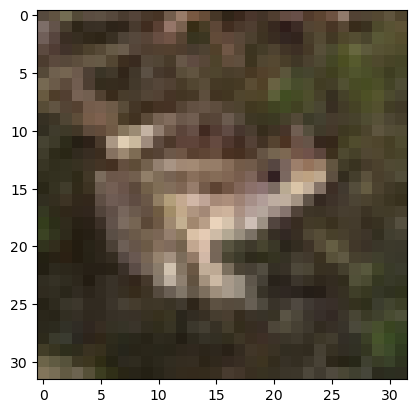

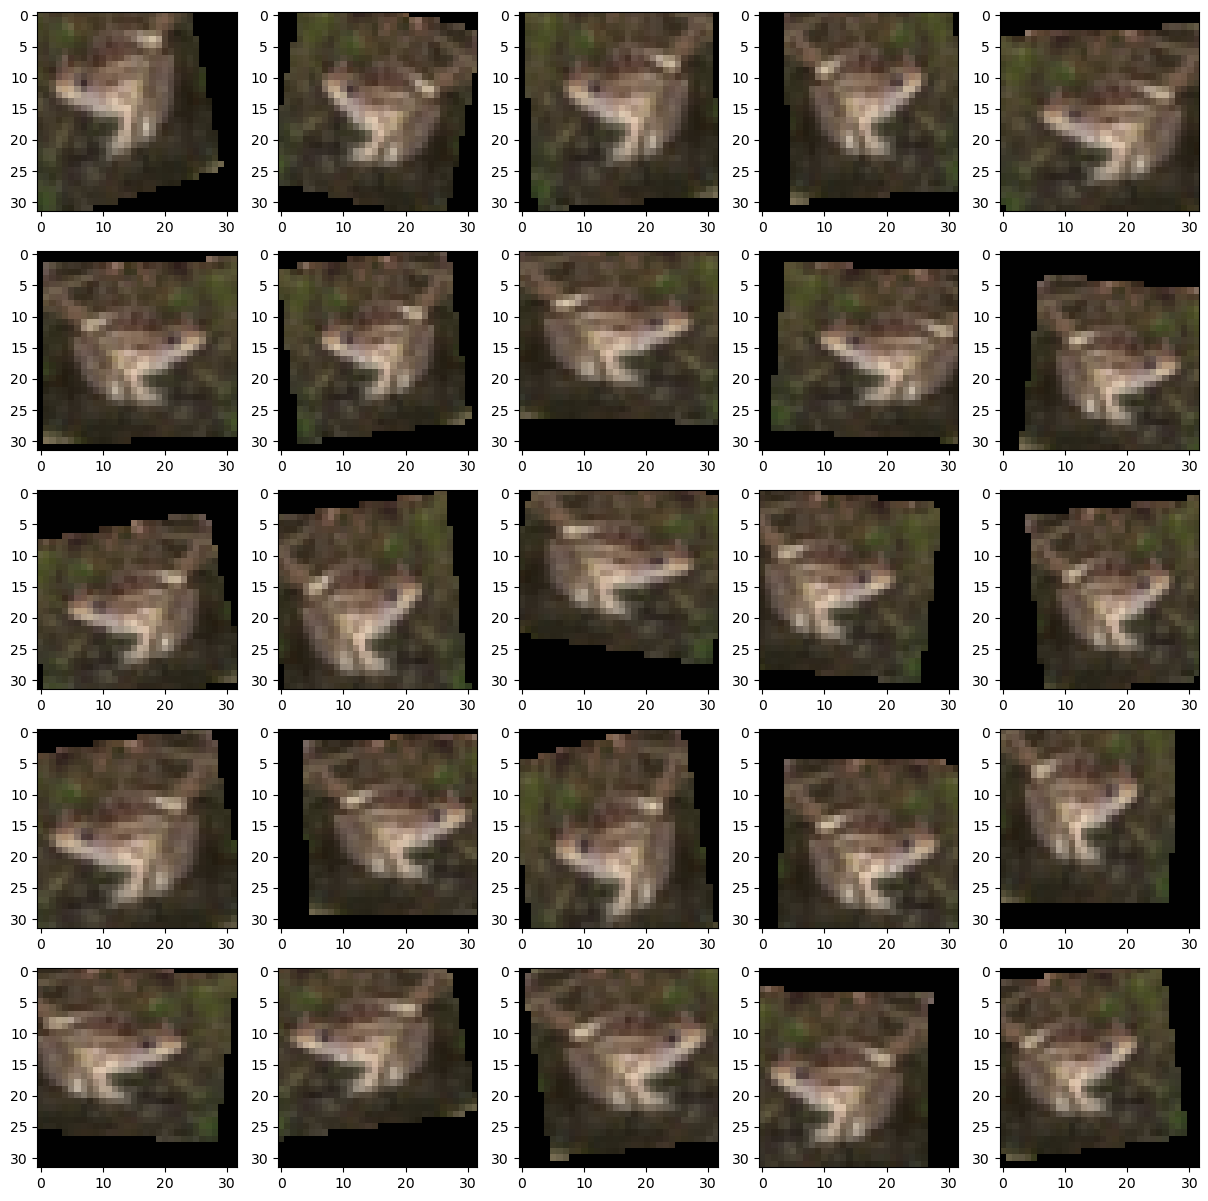

In [55]:
i=22
data_aug=datagen.flow(x=X_train[i:(i+1)], y=Y_train[i:(i+1)], batch_size=1)
plt.imshow(X_train[i])
plt.show()
plt.figure(figsize=(15,15))
for i in range (0,25):
    plt.subplot(5,5,i+1)
    x_aug,y_aug=next(data_aug)
    plt.imshow(x_aug[0].astype("int"), vmin = 0, vmax = 255)

In [29]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=64), 
                              steps_per_epoch=len(X_train)/64, 
                              epochs=40, 
                              validation_data=(X_val, Y_val),
                              verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
157/156 [==============================] - 26s 163ms/step - loss: 2.5899 - accuracy: 0.1870 - val_loss: 1.8868 - val_accuracy: 0.2968
Epoch 2/40
157/156 [==============================] - 26s 164ms/step - loss: 1.8576 - accuracy: 0.3079 - val_loss: 1.7191 - val_accuracy: 0.3661
Epoch 3/40
157/156 [==============================] - 29s 186ms/step - loss: 1.7272 - accuracy: 0.3636 - val_loss: 1.5780 - val_accuracy: 0.4320
Epoch 4/40
157/156 [==============================] - 28s 176ms/step - loss: 1.6437 - accuracy: 0.3992 - val_loss: 1.5234 - val_accuracy: 0.4449
Epoch 5/40
157/156 [==============================] - 21s 135ms/step - loss: 1.5957 - accuracy: 0.4216 - val_loss: 1.4856 - val_accuracy: 0.4562
Epoch 6/40
157/156 [==============================] - 22s 141ms/step - loss: 1.5508 - accuracy: 0.4345 - val_loss: 1.5166 - val_accuracy: 0.4765
Epoch 7/40
157/156 [==============================] - 

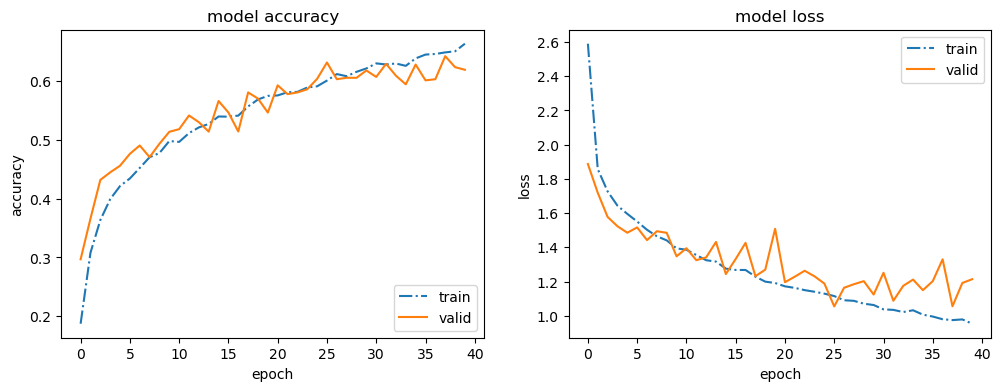

In [30]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [31]:
acc = np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
res6 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch with data augmentation']
)
pd.concat([res1,res2,res3,res4,res5,res6])

,Acc
rf on pixelvalues,0.3930
cnn from scratch without normalization,0.5150
cnn from scratch with normalization,0.5740
cnn from scratch with dropout,0.5604
cnn from scratch with batchnorm,0.5926
cnn from scratch with data augmentation,0.6141


#### Exercise
Try to beat the performace of the best network with your own neutal network.  
*Hint: You might want to combine things from the neural networks above*